# Neural Mutual Information Estimation

In [1]:
%matplotlib inline
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

## Data Generate

In [3]:
# data
var = 0.2
def func(x):
    return x

def gen_x():
    return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_y(x):
    return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

## True Mutual Information

In [4]:
data_size = 1000000
x=gen_x()
y=gen_y(x)
p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi_trad=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))

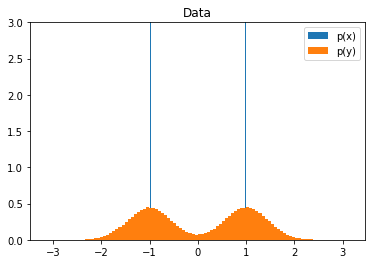

In [5]:
plt.hist(x.ravel(), bins=100, density=True, label='p(x)')
plt.hist(y.ravel(), bins=100, density=True, label='p(y)')
plt.ylim([0, 3])
plt.legend()
plt.title('Data')
plt.savefig('./fig/data.png', dpi=300)

# MINE

$$
KL(p||q) = \underset{f}{\mathrm{sup}}\left[\mathbb{E}_p[f] - \log(\mathbb{E}_q[e^f])\right]
$$

In [6]:
H=10
n_epoch = 500
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
MI_MINE = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = -ret  # maximize
    MI_MINE.append(-loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    

100%|██████████| 500/500 [00:05<00:00, 90.04it/s] 


## MINE using $f$-divergence formulation

$$
KL(p||q) = \underset{f}{\mathrm{sup}}\left[\mathbb{E}_p[f] - \mathbb{E}_q[e^{f-1}]\right]
$$

In [7]:
H=10
n_epoch = 500
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
MI_MINEf = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.mean(torch.exp(pred_x_y - 1))
    loss = -ret  # maximize
    MI_MINEf.append(-loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()
    

100%|██████████| 500/500 [00:04<00:00, 124.32it/s]


# Density Ratio Trick

In [8]:
H=10
n_epoch = 500
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, H)
        self.fc2 = nn.Linear(H, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = self.fc3(h2)
        return h3    

model = Net()
crit = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
plot_loss = []
MI_density_ratio = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = torch.from_numpy(x_sample).type(torch.FloatTensor)
    y_sample = torch.from_numpy(y_sample).type(torch.FloatTensor)
    y_shuffle = torch.from_numpy(y_shuffle).type(torch.FloatTensor)
    
    p_xy = torch.cat([x_sample, y_sample], dim=1)
    p_x_y = torch.cat([x_sample, y_shuffle], dim=1)
    labels = torch.cat([torch.ones(p_xy.size(0)), torch.zeros(p_x_y.size(0))])
    
    data_x = torch.cat([p_xy, p_x_y])
    logits = model(data_x)
    loss = crit(logits, labels.view(-1, 1))
    
    plot_loss.append(loss.data.numpy())
    z = model(p_xy)
    MI_density_ratio.append(((torch.sigmoid(z))/(1-torch.sigmoid(z))).log().mean().data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:10<00:00, 46.29it/s]


# Comparison

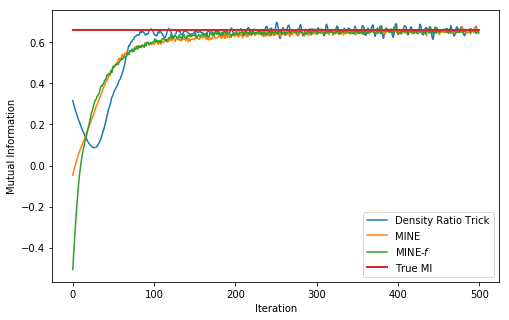

In [9]:
plt.figure(figsize=[8, 5])
plot_x = np.arange(len(MI_density_ratio))
plt.plot(plot_x, MI_density_ratio, label='Density Ratio Trick')
plt.plot(plot_x, MI_MINE, label='MINE')
plt.plot(plot_x, MI_MINEf, label=r'MINE-$f$')
plt.plot(plot_x, [mi_trad] * plot_x.size, label='True MI', linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Mutual Information')
plt.legend()
plt.savefig('./fig/results.png', dpi=300)